In [290]:
# 1. IMPORTS
# ==========================================
# %matplotlib inline
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import re
import missingno as msno
import os

In [291]:
# 2. DICTIONARIES
# ==========================================
# These dictionaries act as the "Medical Brain" of the script. 
# Separating logic from data allows non-coders to update clinical criteria easily.
categories = {
        "Demographics/Vitals": ['Age', 'Gender', 'Weight', 'Height', 'OSat', 'SBP R', 'DBP R', 'Heart rate'],
        "Medications": ['Medications'],
        "Clinical Context": ['Pre-procedure diagnosis', 'Post-procedure diagnosis', 'Year(s) since procedure'],
        "Structural Echo (Dimensions)": ['IVSd', 'LVIDd', 'LVPWd', 'LVIDs', 'Aortic root', 'Left atrium measure', 'Left atrium'],
        "Functional Echo (Hemodynamics)": ['LVEF (categorical)', 'RVSP', 'TR Vmax', 'AO V1 max', 'AO V2 max', 'MS MG (mmHg)']
    }

# Mapping qualitative severity to a quantitative ordinal scale for regression modeling.
severity = {
    'critical': 3.5,
    'severe to critical': 3.25,
    'severe': 3.0,
    'moderate to severe': 2.5,
    'moderate': 2.0,
    'mild to moderate': 1.5,
    'mild': 1.0,
    'none': 0.0
}

# Categorizing interventions to distinguish between surgical and catheter-based outcomes.
procedures = {
    "Surgical" : ['replacement', 'repair', 'patch', 'graft'],
    "Percutaneous" : ['percutaneous valvuloplasty', 'closure', 'stent', 'ablation']
}

# Anatomical targets for multi-lesion extraction.
pathology_patterns = {
    'MS': ['mitral stenosis'],
    'MR': ['mitral regurgitation'],
    'AS':  ['aortic stenosis'],
    'AR': ['aortic regurgitation'],
    'PH': ['pulmonary hypertension'],
    'Septal': ['Secundum atrial septal defect', 'Perimembranous ventricular septal defect', 
               'Ventricular septal defect', 'Incomplete atrioventricular septal defect', 'Sinus venosus atrial septal defect']
}

# Comprehensive pharmacopeia for chronic heart failure and valvular management.
medication_classes = {
    'Beta_Blockers': [
        'Carvedilol', 'Bisoprolol', 'Propranolol', 'Metoprolol', 'Atenolol'
    ],
    'RAAS_Inhibitors': [
        'Enalapril', 'Lisinopril', 'Losartan', 'Valsartan', 'Irbesartan', 
        'Captopril', 'Sacubitril-valsartan'
    ],
    'Diuretics_Loop': [
        'Furosemide'
    ],
    'Diuretics_Other': [
        'Spironolactone', 'Espironolactone', 'Hydrochlorothiazide'
    ],
    'Anticoagulants_Antiplatelets': [
        'Warfarin', 'Warfarine', 'Rivaroxaban', 'Apixaban', 'Aspirin', 'Clopidogrel'
    ],
    'Rate_Rhythm_Control': [
        'Digoxin', 'Amiodarone'
    ],
    'Calcium_Channel_Blockers': [
        'Nifedipine', 'Amlodipine'
    ],
    'SGLT2_Inhibitors': [
        'Dapaglifozin', 'Empaglifozin'
    ],
    'Pulmonary_Vasodilators': [
        'Sildenafil', 'Tadalafil'
    ],
    'Lipid_Lowering': [
        'Simvastatin', 'Rosuvastatin', 'Rosuvastatine', 'Gemfibrozil', 'Ciprofibrate'
    ],
    'Anti_Ischemic_Other': [
        'Trimetazidine', 'Ranolazine'
    ],
    'Metabolic_Endocrine': [
        'Levothyroxine', 'Metformin'
    ]
}

# Multipliers to convert outpatient prescriptions into Total Daily Dose (TDD).
freq_day = {
    'qd': 1, 'bid': 2, 'tid': 3, 'qid': 4
}

# Groupings of echo variables by anatomical and functional units for targeted analysis.
echo_groups = {
            "Mitral": {
                "Parameters": ['MS MG (mmHg)', 'Left atrium', 'LVIDd', 'LVIDs'],
                "Severity_Cols": ['Sev_MS', 'Sev_MR']
            },
            "Aortic": {
                "Parameters": ['AO V1 max', 'AO V2 max', 'Aortic root', 'IVSd', 'LVPWd'],
                "Severity_Cols": ['Sev_AS', 'Sev_AR']
            },
            "PH": {
                "Parameters": ['RVSP', 'TR Vmax'],
                "Severity_Cols": ['Sev_PH'] 
            }
        }

# Groupings for left atrium findings' normalization
la_patterns = {
        4.0: r'(?:huge|severely|severe)',
        2.5: r'(?:moderately|moderate)',
        1.0: r'(?:mild)'
    }

# Reference for Max Doses (simplified for mission triage)
max_doses = {
    # RAAS Inhibitors & Heart Failure
    'Sacubitril-valsartan': 400.0, # 200mg BID
    'Enalapril': 40.0,
    'Lisinopril': 40.0,
    'Losartan': 100.0,
    'Valsartan': 320.0,
    'Irbesartan': 300.0,
    'Captopril': 150.0,
    
    # Beta Blockers
    'Carvedilol': 50.0,
    'Bisoprolol': 10.0,
    'Metoprolol': 200.0,
    'Atenolol': 100.0,
    'Propranolol': 160.0,
    
    # Diuretics & Vasodilators
    'Furosemide': 80.0,      # Standard outpatient ceiling
    'Spironolactone': 50.0,  # Heart failure dose
    'Hydrochlorothiazide': 25.0,
    'Sildenafil': 60.0,      # 20mg TID for PH
    'Tadalafil': 40.0,
    
    # Rate & Rhythm
    'Digoxin': 0.25,
    'Amiodarone': 400.0,     # Maintenance dose
    
    # Anticoagulants & Antiplatelets (Usually fixed dose, intensity = 1.0)
    'Warfarin': 5.0,         # Variable, but 5mg is a common baseline
    'Rivaroxaban': 20.0,
    'Apixaban': 10.0,
    'Aspirin': 100.0,
    'Clopidogrel': 75.0,
    
    # CCBs & Anti-Ischemic
    'Nifedipine': 90.0,
    'Amlodipine': 10.0,
    'Trimetazidine': 70.0,
    'Ranolazine': 1000.0,
    
    # Metabolic & SGLT2i
    'Dapaglifozin': 10.0,
    'Empaglifozin': 25.0,
    'Metformin': 2000.0,
    'Levothyroxine': 0.2,    # 200mcg
    
    # Lipid Lowering
    'Simvastatin': 40.0,
    'Rosuvastatin': 40.0,
    'Gemfibrozil': 1200.0,
    'Ciprofibrate': 100.0
}

# Clinical weight classes related to heart diseases
# Context: Field Mission Triage
# These weights reflect 'Resource Intensity'. 
# A high MBI (Medication Burden) suggests a patient requiring closer 
# follow-up or higher risk of decompensation in low-resource settings.
class_weights = {
    'Diuretics_Loop': 3.0,
    'Pulmonary_Vasodilators': 3.0,
    'RAAS_Inhibitors': 2.0,
    'SGLT2_Inhibitors': 2.0,
    'Diuretics_Other': 2.0,
    'Beta_Blockers': 2.0,
    'Rate_Rhythm_Control': 1.0,
    'Anticoagulants_Antiplatelets': 1.0,
    'Calcium_Channel_Blockers': 1.0,
    'Anti_Ischemic_Other': 1.0,
    'Lipid_Lowering': 0.5,
    'Metabolic_Endocrine': 0.5
}

In [292]:
# 3. CLASSES AND FUNCTIONS
# ==========================================
class auditor:
    """
    Acts as the 'Quality Control' station. 
    Before any analysis, we must identify 'Missing Not At Random' (MNAR) patterns 
    often caused by limited time during medical brigades.
    """
    def __init__(self, dataframe):
        self.df = dataframe.copy()

    def report(self):
        """
        Generates a 3-part audit: 
        1. Technical metadata.
        2. Clinical category missingness (shows which exam parts were skipped).
        3. Lexicon extraction (identifies unique raw strings for manual review).
        """
        audit = []
        for col in self.df.columns:
            audit.append({
                'Column': col,
                'Inferred dtype': self.df[col].dtype,
                'Null Count': self.df[col].isnull().sum(),
                'Sample Values': self.df[col].dropna().unique()[:3].tolist()
            })
        
        # Clinical NLP: Extracting the vocabulary used by the doctors in the field.
        all_diagnoses = pd.concat([
            self.df['Pre-procedure diagnosis'],
            self.df['Post-procedure diagnosis']
        ]).str.split(',').explode().str.strip().dropna().unique()

        all_medications = self.df['Medications'].str.split('|').explode().str.strip().dropna()
        medications_unique = all_medications.str.split(' ').str[0].str.capitalize().unique()

        # Reporting Missingness by Clinical Grouping
        print(f"Current columns by category:\n{'-'*40}")
        for category, cols in categories.items():
            print(f"{category}: {cols}")

        group_report = {}
        missing_from_categories = []
        for group, cols in categories.items():
            # Checks if our expected columns actually exist in the CSV header
            not_found = [c for c in cols if c not in self.df.columns]
            found = [c for c in cols if c in self.df.columns]

            # This logs missing columns
            if not_found:
                missing_from_categories.extend(not_found)
                print(f"\nWarning in {group}: Missing from CSV: {not_found}")
            
            # This calculates mean missingness for found columns
            if found:
                avg_miss = self.df[found].isnull().mean().mean() * 100
                group_report[group] = f"{avg_miss:.2f}% missing"
            else:
                group_report[group] = "N/A - No columns found"

        print("\nMean missingness by category (%):")
        print(f"{'-'*40}")
        print(pd.Series(group_report))

        # Persistence: Ensuring we have an 'Audit Trail' for clinical accountability.
        audit_df = pd.DataFrame(audit)
        pd.DataFrame({'All_diagnoses_list': all_diagnoses}).to_csv('all_diagnoses_report.csv', index=False)
        pd.DataFrame({'All_medications_list': medications_unique}).to_csv('all_medications_report.csv', index=False)
        audit_df.to_csv('dataset_audit_report.csv', index=False)

        print('\nAudit report generated:\n' + f"{'-'*40}")
        print('Technical metadata file generated: dataset_audit_report.csv. ')
        print('All unique diagnoses list generated: all_diagnoses_report.csv.')
        print('All medications list generated: all_medications_report.csv.')

        return audit_df
    
    def echo_missingness(self):
        """
        Forensic Data Audit: 
        Calculates completion rates (%) per column, stratified by 
        disease severity and clinical grouping.
        """
        results = []
        # Access the global or passed echo_groups
        for unit, groups in echo_groups.items():
            # Check for 'Severity_Cols' (ensure the string matches exactly)
            for sev_col in groups["Severity_Cols"]: 
                if sev_col not in self.df.columns:
                    continue

                for sev_level in sorted(self.df[sev_col].unique()):
                    subset = self.df[self.df[sev_col] == sev_level]
                    if subset.empty: continue

                    for param in groups["Parameters"]:
                        if param in self.df.columns:
                            completeness = (1 - subset[param].isnull().mean()) * 100
                            results.append({
                                'Pathology': sev_col.replace('Sev_', ''),
                                'Severity': sev_level,
                                'Parameter': param,
                                'Completeness_Pct': round(completeness, 2),
                                'N': len(subset)
                            })
        
        missings_stratified = pd.DataFrame(results)
        # Pivot for 'Triage Matrix' visualization. 
        pivot_audit = missings_stratified.pivot_table(
            index=['Pathology', 'Parameter'], 
            columns='Severity', 
            values='Completeness_Pct' 
        )
        
        print("Triage proxy pivot table" + "\n" + "-"*40)
        print("Rows: Pathology-Parameter pairs")
        print("Columns: Clinical Severity (0.0 to 3.5)\n")
        return pivot_audit

class extractor:
    """
    The 'Refinery'. Transforms messy clinical strings into 'Tidy' structured data.
    Key philosophy: Do not oversimplify. Preserve mixed valvular disease signatures.
    """
    def __init__(self, dataframe):
        self.df = dataframe.copy()
        self.severities = list(severity.keys())
        # Regex to strip intensity (e.g., 'Severe') to isolate the anatomy.
        self.strip_pattern = r'\b(' + '|'.join(self.severities) + r')\b'

    def _get_expanded_diag(self, col_name):
        """Handles comma-separated lists in a single cell."""
        return self.df[col_name].str.lower().str.split(',').explode().str.strip().dropna()

    def _clean_column(self, col):
        """Standardizes anatomy by removing qualitative noise and surgical terms."""
        s = self._get_expanded_diag(col)
        cleaned = s.str.replace(self.strip_pattern, '', regex=True) \
            .str.replace(r'\s+', ' ', regex=True) \
            .str.strip() \
            .str.capitalize()

        # Group back to original rows to maintain 1:1 patient mapping.
        return cleaned.groupby(level=0).agg(lambda x: ', '.join(x.unique()) if x.any() else np.nan)

    def _parse_meds(self, med_string, drug_list):
        """
        Pharmacological Parser:
        Identifies drug, extracts base dose, and applies frequency multipliers (e.g., bid=x2).
        """
        if pd.isna(med_string) or med_string == "":
            return "None", 0.0
        
        individual_meds = [m.strip().lower() for m in str(med_string).split('|')]
        
        for med_entry in individual_meds:
            matched_drug = next((d for d in drug_list if d.lower() in med_entry), None)
            
            if matched_drug:
                # Extract dose number (handles decimals like 6.25)
                dose_match = re.search(r'(\d+\.?\d*)', med_entry)
                base_dose = float(dose_match.group(1)) if dose_match else 0.0
                
                # Determine frequency multiplier
                multiplier = 1 
                for freq, value in freq_day.items():
                    if f" {freq}" in f" {med_entry}": # Basic word boundary check
                        multiplier = value
                        break
                
                return matched_drug.capitalize(), base_dose * multiplier
                
        return "None", 0.0

    def transform(self):
        """
        Main orchestration of the feature engineering process.
        Creates a multidimensional lesion matrix (e.g., separate columns for MS and MR severity).
        """
        # 1. Anatomy Extraction (The 'What' is involved)
        self.df['Anatomy_Pre'] = self._clean_column('Pre-procedure diagnosis')
        self.df['Anatomy_Post'] = self._clean_column('Post-procedure diagnosis')

        # 2. Multidimensional Severity Mapping (The 'How Bad' is it?)
        def severity_score(text_series, path_regex):
            entries = str(text_series).lower().split(',')
            for entry in entries:
                if re.search(path_regex, entry):
                    for label, score in severity.items():
                        if label in entry: return score
            return 0.0

        for lesion, keywords in pathology_patterns.items():
            col_name = f'Sev_{lesion}'
            pattern = '|'.join(keywords) 
            self.df[col_name] = self.df['Pre-procedure diagnosis'].fillna('').apply(
                lambda x: severity_score(x, pattern)
            )

        # 3. Procedural Classification (The 'Approach')
        self.df['Approach'] = 'Native'
        post_exploded = self._get_expanded_diag('Post-procedure diagnosis')

        for group, keywords in procedures.items():
            pattern = '|'.join(keywords)
            idx = post_exploded[post_exploded.str.contains(pattern, regex=True, na=False)].index
            self.df.loc[idx, 'Approach'] = group

        # 4. Pharmacological Quantification
        for category, drugs in medication_classes.items():
            name_col = f"{category}_name"
            dose_col = f"{category}_tdd"
            
            # Use the internal _parse_meds method
            self.df[[name_col, dose_col]] = self.df['Medications'].apply(
                lambda x: pd.Series(self._parse_meds(x, drugs))
            )

        # 5. Left Atrium Size Scoring
        self.df['LA_Size_Score'] = 0.0
        self.df['LA_Thrombus'] = 0
        self.df['LA_Mass'] = 0
        
        for score, pattern in la_patterns.items():
            # Only update if current score is lower (preserves the highest severity found)
            mask = self.df['Left atrium'].str.contains(pattern, case=False, na=False, regex=True)
            self.df.loc[mask, 'LA_Size_Score'] = np.maximum(self.df.loc[mask, 'LA_Size_Score'], score)

        # 3. Pathological Findings (Flags)
        # Thrombus/Clot/Smoke (Spontaneous Echo Contrast)
        thrombus_pattern = r'(?:thrombus)'
        self.df['LA_Thrombus'] = self.df['Left atrium'].str.contains(thrombus_pattern, case=False, na=False, regex=True).astype(int)

        # Masses (Myxomas)
        mass_pattern = r'(?:myxoma)'
        self.df['LA_Mass'] = self.df['Left atrium'].str.contains(mass_pattern, case=False, na=False, regex=True).astype(int)
        
        return self.df

    def diagnoses_prevalence(self):
        """Standardizes and counts the global disease burden in the cohort."""
        if 'Anatomy_Pre' not in self.df.columns:
            self.transform()

        pre = self.df['Anatomy_Pre'].str.split(', ').explode()
        post = self.df['Anatomy_Post'].str.split(', ').explode()

        return pd.concat([pre, post]).value_counts()
    
    def disease_profiler(self):
        '''
        Identifies complex interactions: Mixed Lesions, Shunts, and Rhythm Confounders.
        '''
        if 'Sev_MS' not in self.df.columns:
            self.transform()

        # 1. Mixed Valvular Disease (Same-valve: Stenosis + Regurgitation)
        self.df['Mixed_Mitral'] = ((self.df['Sev_MS'] > 0) & (self.df['Sev_MR'] > 0)).astype(int)
        self.df['Mixed_Aortic'] = ((self.df['Sev_AS'] > 0) & (self.df['Sev_AR'] > 0)).astype(int)

        # 2. Multi-Valvular Disease (Cross-valve: Mitral unit AND Aortic unit)
        mitral_any = (self.df['Sev_MS'] > 0) | (self.df['Sev_MR'] > 0)
        aortic_any = (self.df['Sev_AS'] > 0) | (self.df['Sev_AR'] > 0)
        self.df['Multi_Valve'] = (mitral_any & aortic_any).astype(int)

        # 3. Pulmonary Hypertension (Explicit Flag)
        # Defined here as any PH mention (Severity > 0)
        self.df['PH_Present'] = (self.df['Sev_PH'] > 0).astype(int)

        # 4. Shunts (Septal Defects)
        shunt_pattern = '|'.join(pathology_patterns['Septal'])
        self.df['Has_Shunt'] = self.df['Pre-procedure diagnosis'].str.contains(
            shunt_pattern, case=False, na=False, regex=True
        ).astype(int)

        # 5. Rhythm Confounders (AFib)
        self.df['AFib_Present'] = self.df['Pre-procedure diagnosis'].str.contains(
            'Atrial fibrillation', case=False, na=False, regex=True
        ).astype(int)

        # 6. Global Complexity Score 
        # Summing binary flags. Note: For PH, we only count it as a 'Complexity Point' 
        # if it is Moderate or worse (>= 2.0), as Mild PH is very common.
        self.df['Complexity_Score'] = (
            self.df['Mixed_Mitral'] + 
            self.df['Mixed_Aortic'] + 
            self.df['Multi_Valve'] + 
            self.df['Has_Shunt'] + 
            self.df['AFib_Present'] + 
            (self.df['Sev_PH'] >= 2.0).astype(int)
        )

        # Accurate Prevalence Reporting
        self.complexity_stats = {
            "Total Patients": len(self.df),
            "Mixed Mitral": self.df['Mixed_Mitral'].sum(),
            "Mixed Aortic": self.df['Mixed_Aortic'].sum(),
            "Multi-Valvular": self.df['Multi_Valve'].sum(),
            "Any PH Mention": self.df['PH_Present'].sum(),
            "AFib Present": self.df['AFib_Present'].sum()
        }

        return self.df
    
    def complexity_report(self):
        """
        Returns the stats as a clean Pandas Series for easy display or export.
        """
        print("Complex cases\n" + '-'*40)
        print("Cases that have either mixed, multiple valvular disease and/or other conditions\n")
        if hasattr(self, 'complexity_stats'):
            return pd.Series(self.complexity_stats, name="Prevalence")
        else:
            return "Profiler has not been run yet."

class calculator:
    def __init__(self, dataframe):
        self.df = dataframe.copy()

    def medication_index(self):
        """
        Computes the Medication Burden Index (MBI).
        MBI = Sum(Class_Weight * (Actual_TDD / Max_TDD))
        """
        self.df['MBI'] = 0.0

        for category, weight in class_weights.items():
            name_col = f"{category}_name"
            dose_col = f"{category}_tdd"

            if name_col in self.df.columns:
                # Vectorized calculation for each class
                # Uses 1.0 as a fallback intensity for fixed-dose meds (like Aspirin)
                intensity = self.df.apply(
                    lambda x: x[dose_col] / max_doses.get(x[name_col], x[dose_col]) 
                    if x[dose_col] > 0 else 0, axis=1
                )
                # Clips intensity at 1.0 (to avoid outliers from rare supra-therapeutic doses)
                self.df['MBI'] += (intensity.clip(upper=1.0) * weight)
            
        return self.df
    
class visualizer:
    def __init__(self, dataframe):
        self.df = dataframe.copy()
    
    def patient_nullity(self, list):
        # Forensic Audit: Visualizing data deserts to evaluate mission-specific documentation constraints.
        available_keys = [v for v in list if v in self.df.columns]
        print("Patient-Level Nullity Patterns Visualization" + "\n" + "-"*40)
        plt.figure(figsize=(10, 6))
        msno.matrix(self.df[available_keys], sparkline=False, color=(0.1, 0.3, 0.5))
        plt.title("Nullity Matrix: Are key indicators captured together?", fontsize=14)
        plt.show()

        # This is the 'Smoking Gun' for Imputation
        print("Correlation of Missingness (1.0 = Always missing together):" + "\n" + "-"*40)
        msno.heatmap(self.df[available_keys], cmap='GnBu')
        plt.show()
    
    def echo_matrix(self, table):
        # Triage Efficiency: Quantifying which physiological parameters are deemed 'Critical Path' by the field team.
        print("\nEchocardiogram Triage Matrix notes:" + "\n" + "-"*40)
        print("A 'Hot' cell (High %) indicates a parameter the cardiologist deemed mandatory for triage.")
        plt.figure(figsize=(14, 10))

        # Using a sequential colormap (YlOrRd) to highlight 'Data Deserts' vs 'Data Oases'.
        sns.heatmap(table.fillna(0), annot=True, fmt=".1f", cmap="YlOrRd", cbar_kws={'label': 'Completeness %'})

        plt.title("Echocardiogram Triage Matrix: Data Presence as a Function of Disease Severity", fontsize=15)
        plt.xlabel("Clinician-Assessed Severity (Ordinal Scale)")
        plt.ylabel("Echocardiographic Parameter by Pathology")
        plt.show()
    
    def complexity_frequency(self):
            """
            Visualizes the phenotypic burden of the cohort.
            """
            plt.figure(figsize=(10, 6))
            
            # Count frequencies of each score
            counts = self.df['Complexity_Score'].value_counts().sort_index()
            
            # Create a bar plot
            sns.barplot(x=counts.index, y=counts.values, hue=counts.index, palette="YlOrRd", legend=False)
            
            plt.title("Distribution of Patient Complexity Scores", fontsize=15)
            plt.xlabel("Complexity Score (0 = Simple, 5+ = Highly Complex)", fontsize=12)
            plt.ylabel("Number of Patients", fontsize=12)
            
            # Add labels on top of bars
            for i, val in enumerate(counts.values):
                plt.text(i, val + 0.5, str(val), ha='center', fontsize=11, fontweight='bold')
                
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.show()
    
    def complexity_markers(self):
            """
            Shows the prevalence of specific complexity markers.
            """
            markers = ['Mixed_Mitral', 'Mixed_Aortic', 'Multi_Valve', 'Has_Shunt', 'AFib_Present', 'PH_Present']
            prevalence = self.df[markers].sum().sort_values(ascending=False)
            
            plt.figure(figsize=(10, 6))
            prevalence.plot(kind='barh', color='#e34a33')
            plt.title("Prevalence of Complexity Markers", fontsize=15)
            plt.xlabel("Patient Count", fontsize=12)
            plt.gca().invert_yaxis()
            plt.show()

    def complexity_heatmap(self):
        # Interaction Analysis: Identifying 'Syndromic Clusters' where multiple pathologies co-exist, increasing clinical risk.
        cols = ['Mixed_Mitral', 'Mixed_Aortic', 'Multi_Valve', 
                'Has_Shunt', 'AFib_Present', 'PH_Present']
        
        # Calculate the correlation (co-occurrence)
        # We use 'pearson' here to see how strongly one predicts the other
        interaction_matrix = self.df[cols].corr()

        plt.figure(figsize=(10, 8))
        sns.heatmap(interaction_matrix, annot=True, cmap='RdBu_r', center=0, fmt=".2f")
        
        plt.title("Clinical Interaction Heatmap: Pathological Clustering", fontsize=15)
        plt.tight_layout()
        plt.show()

# SUMMARY FUNCTION
# ------------------------------------------
def generate_mission_report(df, complexity_stats):
    """
    Final output for Brigade Leadership. 
    Summarizes volume, complexity, and resource burden.
    """
    total = len(df)
    high_risk_pct = (df['Complexity_Score'] >= 2).mean() * 100
    avg_mbi = df['MBI'].mean()
    
    # Identify top pathology using the Anatomy columns you created
    top_pathology = df['Anatomy_Pre'].str.split(', ').explode().mode()[0]

    print(f"""
    {"="*45}
    BRIGADE EXECUTIVE SUMMARY: PHL 2025
    {"="*45}
    1. PATIENT VOLUME: {total} total evaluations performed.
    2. CLINICAL BURDEN: {high_risk_pct:.1f}% of the cohort presented with 
       Complex/Multi-valvular disease profiles.
    3. DOMINANT PATHOLOGY: {top_pathology} was the most frequent finding.
    4. MEDICATION BURDEN: Mean MBI is {avg_mbi:.2f}. 
       (A higher score indicates greater pharmacological dependency).
    
    * DOCUMENTATION FIDELITY: Triage Matrix and Audit Logs generated.
    {"="*45}
    """)

In [293]:
# 4. EXECUTIONS
# ==========================================
df = pd.read_csv('phl_2025.csv')
# Set theme for visualizations
sns.set_theme(style="whitegrid")
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=sns.color_palette("YlOrRd", 6))

'''
Step 1: Baseline Integrity Audit
'''
aud = auditor(df)
audit_report = aud.report()
audit_report.head()

Current columns by category:
----------------------------------------
Demographics/Vitals: ['Age', 'Gender', 'Weight', 'Height', 'OSat', 'SBP R', 'DBP R', 'Heart rate']
Medications: ['Medications']
Clinical Context: ['Pre-procedure diagnosis', 'Post-procedure diagnosis', 'Year(s) since procedure']
Structural Echo (Dimensions): ['IVSd', 'LVIDd', 'LVPWd', 'LVIDs', 'Aortic root', 'Left atrium measure', 'Left atrium']
Functional Echo (Hemodynamics): ['LVEF (categorical)', 'RVSP', 'TR Vmax', 'AO V1 max', 'AO V2 max', 'MS MG (mmHg)']

Mean missingness by category (%):
----------------------------------------
Demographics/Vitals                0.58% missing
Medications                        8.55% missing
Clinical Context                  46.05% missing
Structural Echo (Dimensions)      81.77% missing
Functional Echo (Hemodynamics)    66.89% missing
dtype: object

Audit report generated:
----------------------------------------
Technical metadata file generated: dataset_audit_report.csv. 
All

,Column,Inferred dtype,Null Count,Sample Values
0,ID,int64,0,"[152, 151, 150]"
1,DoB,object,0,"[18-Sep-94, 30-Nov-04, 14-Sep-51]"
2,Age,int64,0,"[30, 20, 73]"
3,Gender,object,0,"[Male, Female]"
4,Pre-procedure diagnosis,object,0,"[Bicuspid aortic valve, Secundum atrial septal..."



Patient-Level Nullity Patterns Visualization
----------------------------------------


<Figure size 1000x600 with 0 Axes>

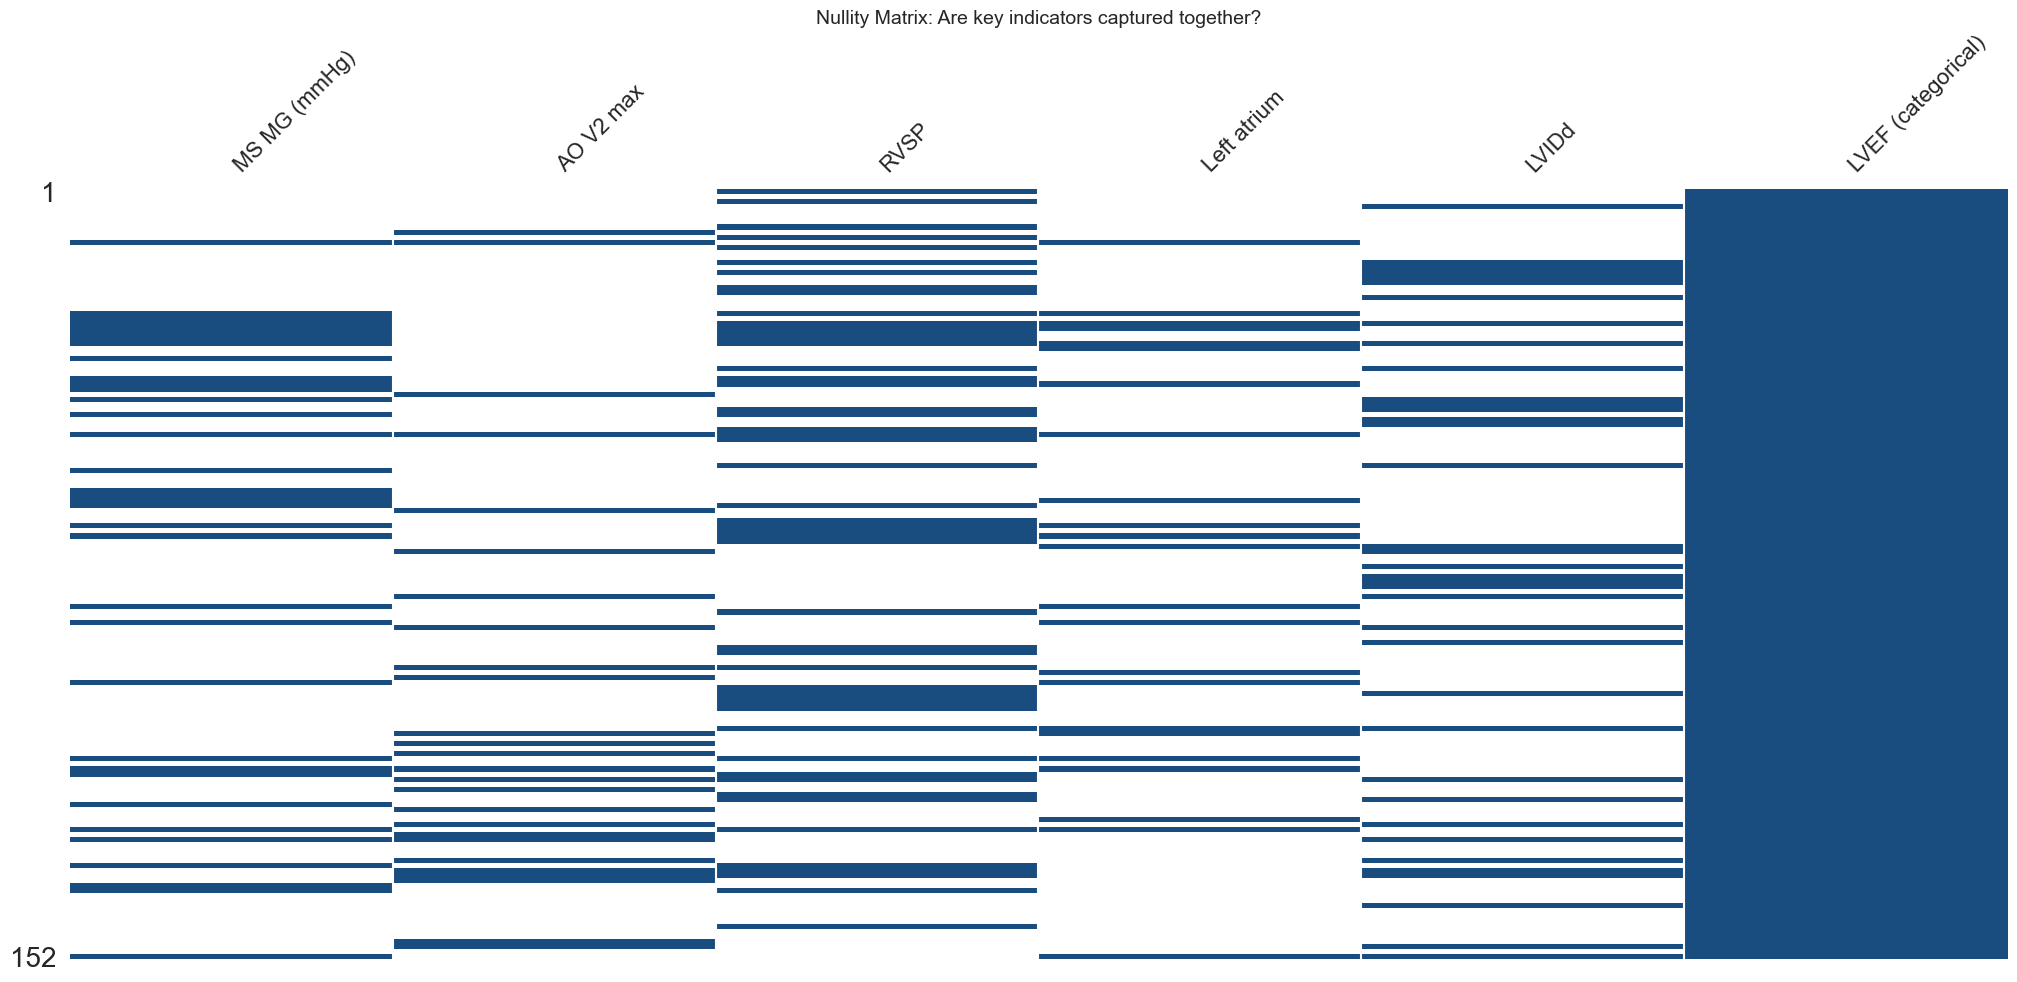

Correlation of Missingness (1.0 = Always missing together):
----------------------------------------


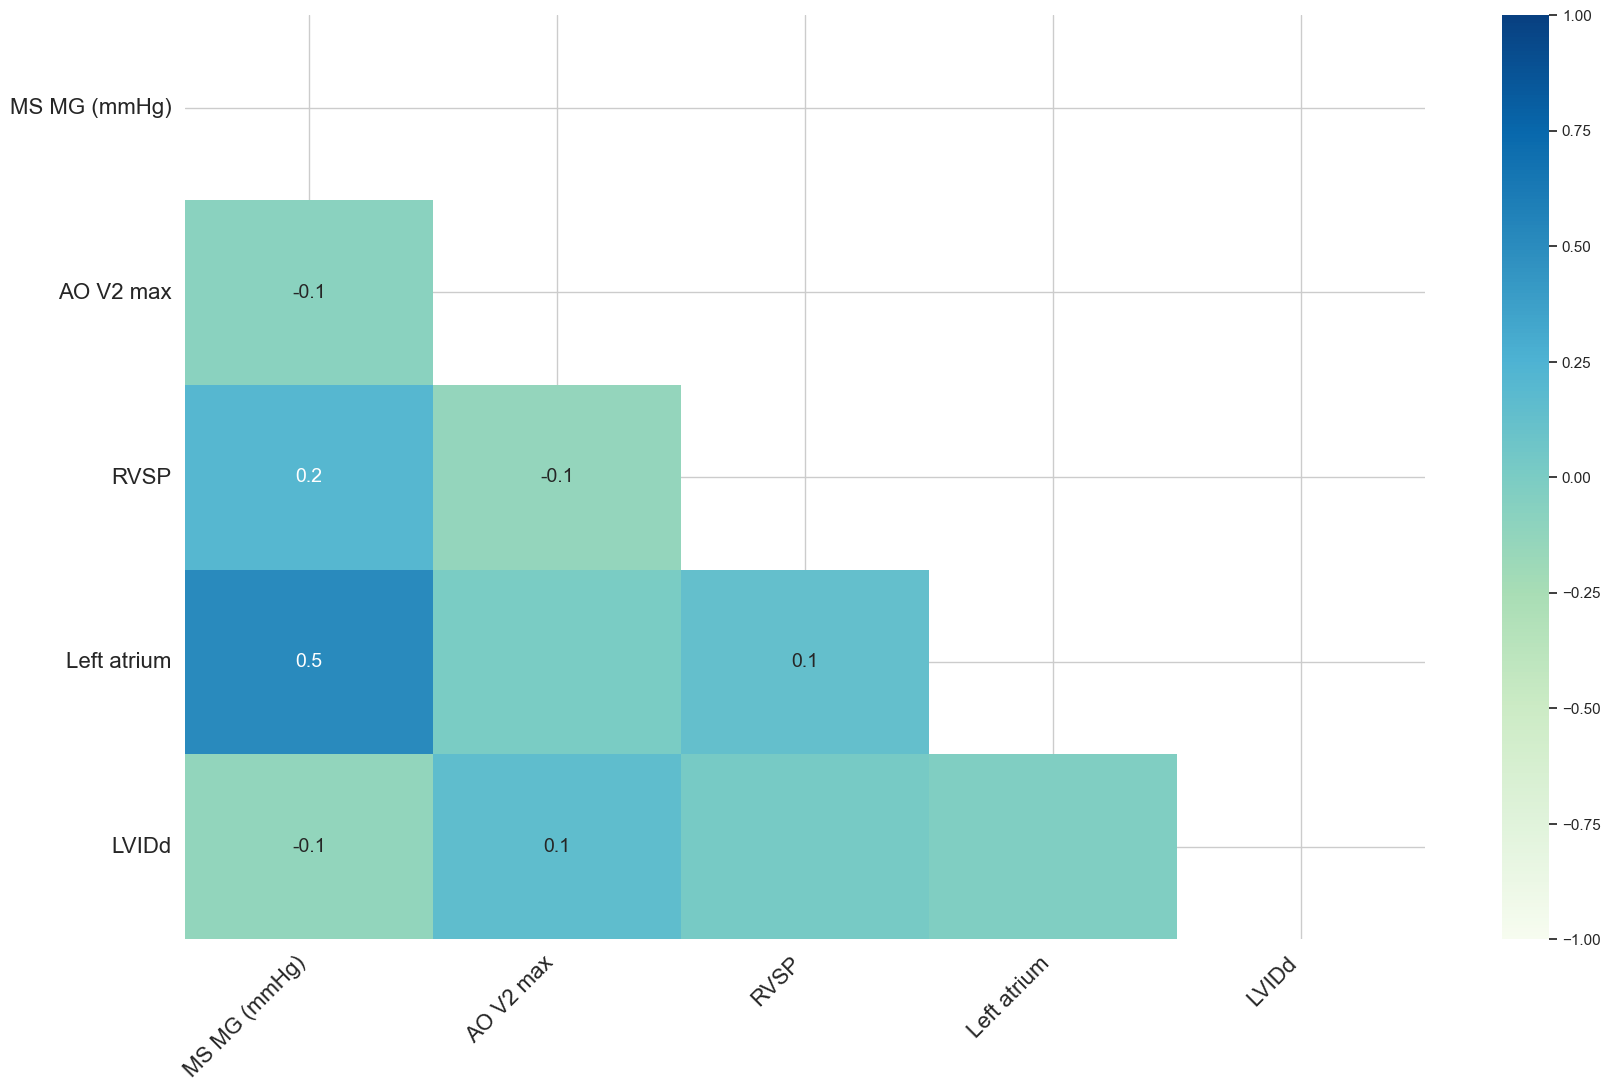

In [294]:
'''
Step 2: Patient-Level Nullity Correlation
'''
# Executing the 'Refinery': Mapping raw text to a multi-dimensional severity matrix.
ext = extractor(df)
parsed = ext.transform()
parsed = ext.disease_profiler()
calc = calculator(parsed)
calculated = calc.medication_index()
# This ensures we include the feature engineered columns from the extractor class
aud = auditor(parsed)

print('')

# Identifying if variables are 'missing together' (Systemic Triage) or 'randomly missing' (Data entry error).
key_vars = [
    'MS MG (mmHg)', 'AO V2 max', 'RVSP', 
    'Left atrium', 'LVIDd', 'LVEF (categorical)'
]

# Filter for relevant columns that exist in parsed
viz = visualizer(parsed)
nullity_patterns = viz.patient_nullity(key_vars)

Triage proxy pivot table
----------------------------------------
Rows: Pathology-Parameter pairs
Columns: Clinical Severity (0.0 to 3.5)

Severity                  0.0    1.0     2.0    3.0   3.5
Pathology Parameter                                      
AR        AO V1 max      6.47    NaN   20.00  25.00   NaN
          AO V2 max     16.55    NaN    0.00  37.50   NaN
          Aortic root   14.39    NaN   60.00  37.50   NaN
          IVSd          19.42    NaN   20.00  62.50   NaN
          LVPWd         15.83    NaN   20.00  62.50   NaN
AS        AO V1 max      3.39    NaN    0.00  18.18  40.0
          AO V2 max      5.93    NaN   50.00  63.64  40.0
          Aortic root   10.17    NaN   50.00  40.91  40.0
          IVSd          17.80    NaN   50.00  27.27  50.0
          LVPWd         16.10    NaN   50.00  27.27  20.0
MR        LVIDd         23.13   0.00   50.00  30.77   NaN
          LVIDs         18.66   0.00   25.00  30.77   NaN
          Left atrium   13.43   0.00   25.00  30.

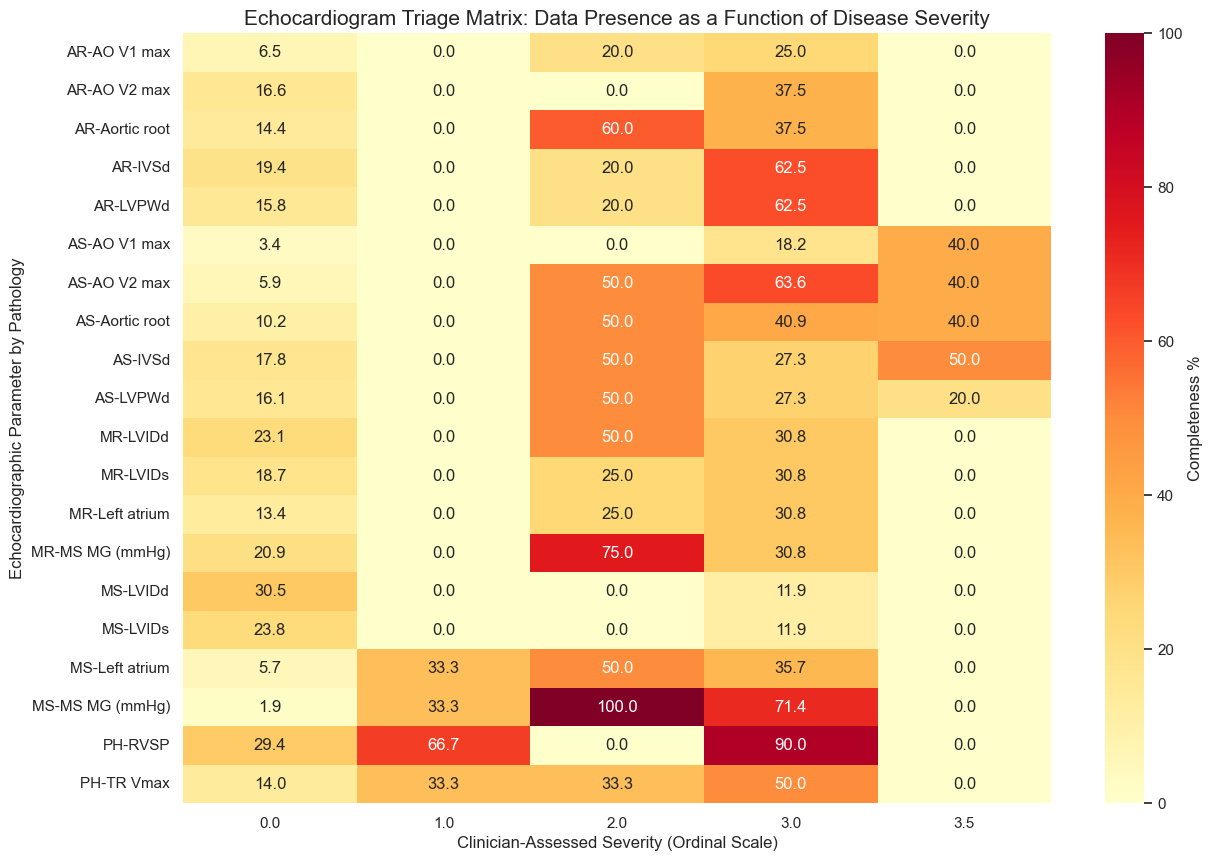

In [295]:
'''
Step 3: Stratified Missingness & Triage Proxy Audit
'''
#Running the echo-specific audit on the 'Refined' data.
# This step proves that MNAR patterns follow clinical suspicion/severity.
missings_table = aud.echo_missingness()
print(missings_table)

# Visualization: The Triage Silhouette
missings_matrix = viz.echo_matrix(missings_table)

In [296]:
'''
Step 4: Extract Disease Burden
'''
# Identifies the most common pathologies treated during the mission.
diagnoses = ext.diagnoses_prevalence()
print('Disease prevalence (n)\n' + '-'*40)
with pd.option_context('display.max_rows', None):
    print(diagnoses.head(10))

Disease prevalence (n)
----------------------------------------
Mitral stenosis                            49
Aortic stenosis                            34
Secundum atrial septal defect              22
Mitral regurgitation                       19
Pulmonary hypertension                     15
Aortic regurgitation                       15
Surgical aortic valve replacement          14
Bicuspid aortic valve                      12
Mitral valve percutaneous valvuloplasty    11
Atrial fibrillation                         9
Name: count, dtype: int64


Complex cases
----------------------------------------
Cases that have either mixed, multiple valvular disease and/or other conditions

Total Patients    152
Mixed Mitral        7
Mixed Aortic        1
Multi-Valvular      8
Any PH Mention     16
AFib Present        7
Name: Prevalence, dtype: int64

High complexity cases
----------------------------------------
Cases that fulfill criteria for two or more groups from above

Identified 6 High-Complexity cases.


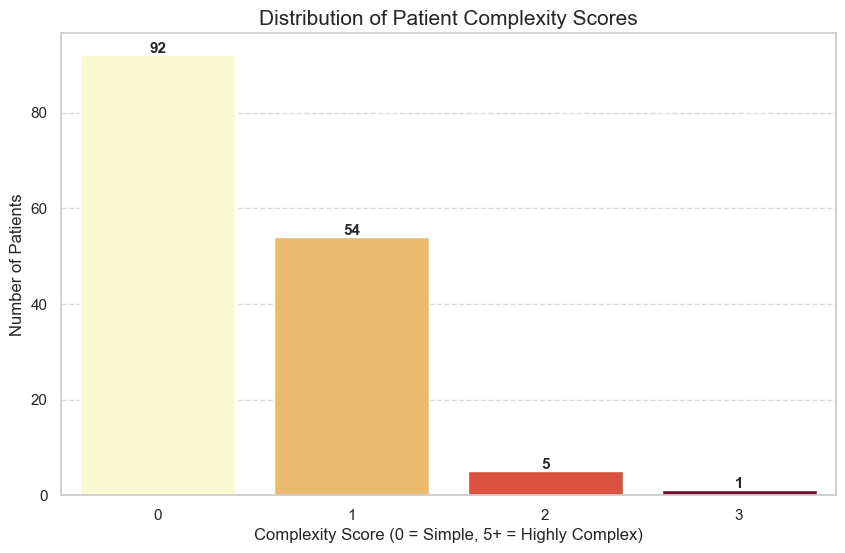

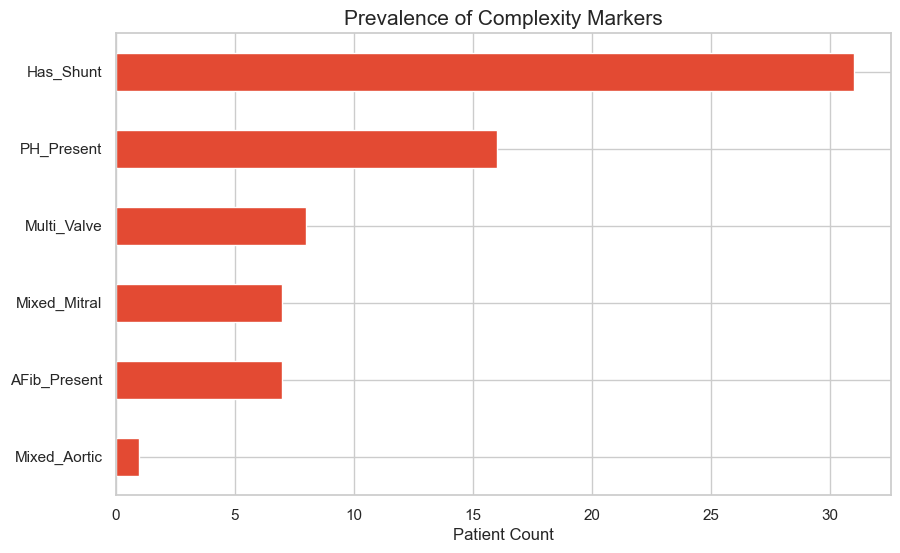

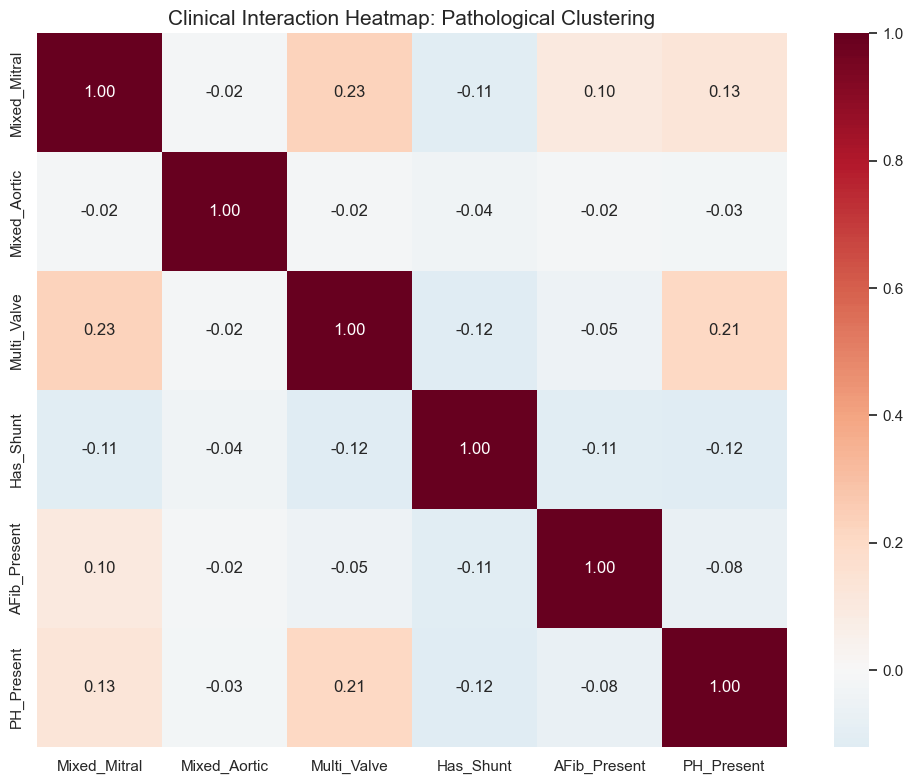

,ID,DoB,Age,Gender,Pre-procedure diagnosis,Post-procedure diagnosis,Year(s) since procedure,Medications,SBP R,DBP R,...,LA_Size_Score,LA_Thrombus,LA_Mass,Mixed_Mitral,Mixed_Aortic,Multi_Valve,PH_Present,Has_Shunt,AFib_Present,Complexity_Score
0,152,18-Sep-94,30,Male,"Bicuspid aortic valve, Secundum atrial septal ...",NaN,NaN,Tadalafil 20 mg QD | Metoprolol 50 mg QD | Spi...,98,63,...,0.0,0,0,0,0,0,0,1,0,1
1,151,30-Nov-04,20,Female,Secundum atrial septal defect,NaN,NaN,Aspirin 100 mg QD,118,68,...,0.0,0,0,0,0,0,0,1,0,1
2,150,14-Sep-51,73,Female,"Left atrium thrombus, Moderate tricuspid regur...",NaN,NaN,Irbesartan 159 mg QD | Carvedilol 6.25 mg QD |...,144,93,...,0.0,0,0,0,0,0,0,0,0,0
3,149,28-Oct-09,15,Female,"Arrhythmogenic right ventricle dysplasia, Prim...",NaN,NaN,Sildenafil 25 mg BID,105,70,...,0.0,0,0,0,0,0,1,0,0,1
4,148,26-Nov-06,18,Male,Mild intracavitary right ventricle muscle bund...,NaN,NaN,NaN,132,78,...,0.0,0,0,0,0,0,0,0,0,0


In [297]:
'''
Step 5: Complex Lesion Discovery
'''
complexity = ext.complexity_report()
print(complexity)

complex_cases = parsed[parsed['Complexity_Score'] >= 2]
print("\nHigh complexity cases\n" + '-'*40)
print("Cases that fulfill criteria for two or more groups from above\n")
print(f"Identified {len(complex_cases)} High-Complexity cases.")

# 1. How complex is the average patient?
viz.complexity_frequency()

# 2. Which specific complexities are most common?
viz.complexity_markers()

# Execute
heatmap = viz.complexity_heatmap()
# Final Export: Ready for Statistical Analysis or Regression
parsed.head()

In [298]:
generate_mission_report(calculated, ext.complexity_stats)


    BRIGADE EXECUTIVE SUMMARY: PHL 2025
    1. PATIENT VOLUME: 152 total evaluations performed.
    2. CLINICAL BURDEN: 3.9% of the cohort presented with 
       Complex/Multi-valvular disease profiles.
    3. DOMINANT PATHOLOGY: Mitral stenosis was the most frequent finding.
    4. MEDICATION BURDEN: Mean MBI is 2.86. 
       (A higher score indicates greater pharmacological dependency).

    * DOCUMENTATION FIDELITY: Triage Matrix and Audit Logs generated.
    


In [299]:
# 5. EXPLORATIONS
# ==========================================

# 1. Identify the maximum severity across all tracked pathologies for each patient
pathology_cols = ['Sev_MS', 'Sev_MR', 'Sev_AS', 'Sev_AR', 'Sev_PH']
calculated['Max_Pathology_Severity'] = calculated[pathology_cols].max(axis=1)

# 2. Refine the Discordance Mask
# True Discordance = High Meds AND (No single pathology is > Moderate)
true_discordance_mask = (
    (calculated['MBI'] >= 5.0) & 
    (calculated['Max_Pathology_Severity'] <= 2.0)
)

# 3. Label the groups for visualization
calculated['Discordance_Type'] = 'Matched'
calculated.loc[(calculated['MBI'] >= 5.0) & (calculated['Max_Pathology_Severity'] > 2.0), 'Discordance_Type'] = 'Explained High Burden'
calculated.loc[true_discordance_mask, 'Discordance_Type'] = 'True Discordance (TEE Priority)'

print(calculated['Discordance_Type'].value_counts())

# Create a Stratified Discordance Table
stratified_discordance = pd.crosstab(
    calculated['Approach'], 
    calculated['Discordance_Type'], 
    normalize='index'
) * 100

print("Percentage of Discordance by Clinical Approach:")
print(stratified_discordance.round(2))

# Filter for intervened patients only
intervened = calculated[calculated['Approach'] != 'Native'].copy()

# Compare MBI and RVSP across intervention types
comparison = intervened.groupby('Approach').agg({
    'MBI': ['mean', 'std', 'max'],
    'Max_Pathology_Severity': 'mean'
}).round(2)

print("\nSurgical Audit: Residual Burden by Intervention Type")
print(comparison)

Discordance_Type
Matched                            125
Explained High Burden               20
True Discordance (TEE Priority)      7
Name: count, dtype: int64
Percentage of Discordance by Clinical Approach:
Discordance_Type  Explained High Burden  Matched  \
Approach                                           
Native                            15.45    78.18   
Percutaneous                      11.76    88.24   
Surgical                           4.00    96.00   

Discordance_Type  True Discordance (TEE Priority)  
Approach                                           
Native                                       6.36  
Percutaneous                                 0.00  
Surgical                                     0.00  

Surgical Audit: Residual Burden by Intervention Type
               MBI             Max_Pathology_Severity
              mean   std   max                   mean
Approach                                             
Percutaneous  3.21  2.59  9.93                   1.94
S

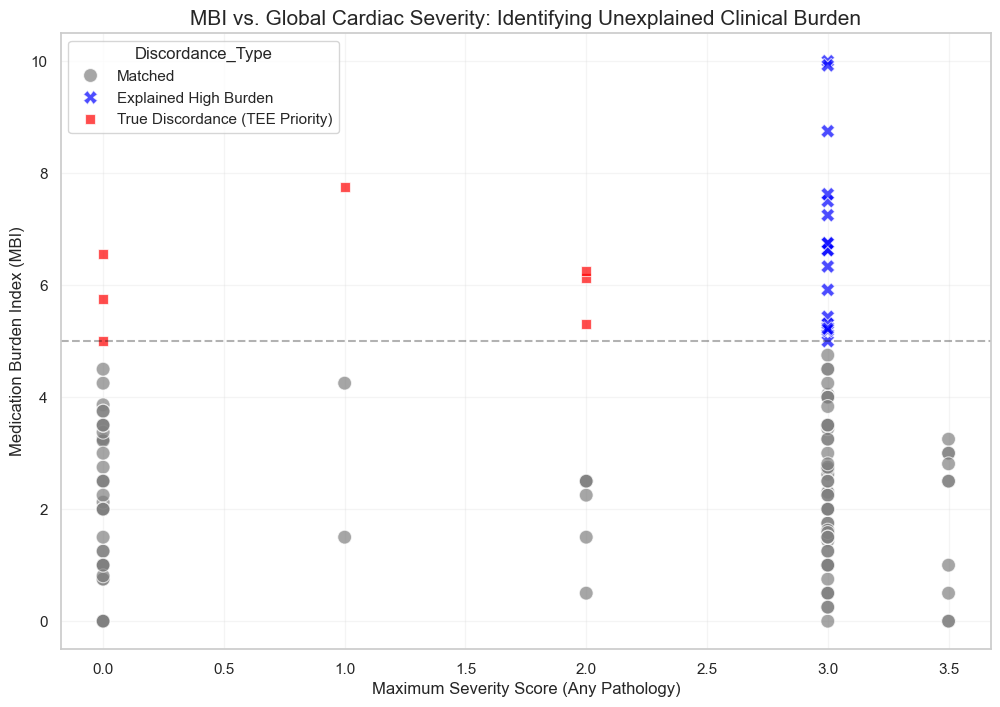

In [301]:
plt.figure(figsize=(12, 8))

sns.scatterplot(
    data=calculated,
    x='Max_Pathology_Severity',
    y='MBI',
    hue='Discordance_Type',
    style='Discordance_Type',
    palette={'Matched': 'grey', 'Explained High Burden': 'blue', 'True Discordance (TEE Priority)': 'red'},
    s=100,
    alpha=0.7
)

plt.axhline(y=5.0, color='black', linestyle='--', alpha=0.3)
plt.title("MBI vs. Global Cardiac Severity: Identifying Unexplained Clinical Burden", fontsize=15)
plt.xlabel("Maximum Severity Score (Any Pathology)", fontsize=12)
plt.ylabel("Medication Burden Index (MBI)", fontsize=12)
plt.grid(True, alpha=0.2)
plt.show()

In [ ]:
# 6. LOG OF CURRENT STATUS OF CODE
# ==========================================
file = 'phl_2025_1.ipynb'
os.system(f"jupyter nbconvert --to markdown {file}")
print(f"Success! Markdown file generated: {file.replace('.ipynb', '.md')}")


Success! Markdown file generated: phl_2025_1.md
